In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/top50spotify2019/top50.csv


# Playing next...

Spotify apps have a feature called "Made for you" which shows a few playlists curated upon the songs that you already liked and added to your library. In this notebook, we will try to build a simple recommender using K-Means clustering to predict which song should play after the one that you've already selected.

### Loading the data

This is a dataset containing Top 50 songs on 2019, along with a few features. Let's have a look at it:

In [2]:
data = pd.read_csv("../input/top50spotify2019/top50.csv",encoding='ISO-8859-1')
data.head()

,Unnamed: 0,Track.Name,Artist.Name,Genre,Beats.Per.Minute,Energy,Danceability,Loudness..dB..,Liveness,Valence.,Length.,Acousticness..,Speechiness.,Popularity
0,1,Señorita,Shawn Mendes,canadian pop,117,55,76,-6,8,75,191,4,3,79
1,2,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,302,8,9,92
2,3,boyfriend (with Social House),Ariana Grande,dance pop,190,80,40,-4,16,70,186,12,46,85
3,4,Beautiful People (feat. Khalid),Ed Sheeran,pop,93,65,64,-8,8,55,198,12,19,86
4,5,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,150,65,58,-4,11,18,175,45,7,94


Let's rename the labels for better understanding:

In [3]:
data.rename(columns={"Beats.Per.Minute":"BPM",
                     "Valence.":"Valence",
                     "Acousticness..":"Acousticness",
                     "Loudness..dB..":"Loudness",
                     "Speechiness.":"Speechiness",
                     "Track.Name":"Track",
                     "Artist.Name":"Artist"},inplace=True)

I'll drop the `Unnamed: 0` and `Length.` features because it seems irrelevant for a recommender system:**

In [4]:
data.drop(["Unnamed: 0","Length."], axis=1,inplace=True)

data.head()

,Track,Artist,Genre,BPM,Energy,Danceability,Loudness,Liveness,Valence,Acousticness,Speechiness,Popularity
0,Señorita,Shawn Mendes,canadian pop,117,55,76,-6,8,75,4,3,79
1,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,8,9,92
2,boyfriend (with Social House),Ariana Grande,dance pop,190,80,40,-4,16,70,12,46,85
3,Beautiful People (feat. Khalid),Ed Sheeran,pop,93,65,64,-8,8,55,12,19,86
4,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,150,65,58,-4,11,18,45,7,94


A lot of these genres are variations of the 'pop' genre. It would be easier to just club them all together into one genre called 'pop':

In [5]:
import re 

for genre in data['Genre']:
    if re.search('pop', genre):
        data.loc[data.Genre == genre, 'Genre'] = 'pop'
        
data.head()


,Track,Artist,Genre,BPM,Energy,Danceability,Loudness,Liveness,Valence,Acousticness,Speechiness,Popularity
0,Señorita,Shawn Mendes,pop,117,55,76,-6,8,75,4,3,79
1,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,8,9,92
2,boyfriend (with Social House),Ariana Grande,pop,190,80,40,-4,16,70,12,46,85
3,Beautiful People (feat. Khalid),Ed Sheeran,pop,93,65,64,-8,8,55,12,19,86
4,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,150,65,58,-4,11,18,45,7,94


Now let's encode all genres using Label Encoding:

In [6]:
from sklearn.preprocessing import LabelEncoder 
  
le = LabelEncoder() 
  
data['Genre']= le.fit_transform(data['Genre']) 

data.head()

,Track,Artist,Genre,BPM,Energy,Danceability,Loudness,Liveness,Valence,Acousticness,Speechiness,Popularity
0,Señorita,Shawn Mendes,10,117,55,76,-6,8,75,4,3,79
1,China,Anuel AA,13,105,81,79,-4,8,61,8,9,92
2,boyfriend (with Social House),Ariana Grande,10,190,80,40,-4,16,70,12,46,85
3,Beautiful People (feat. Khalid),Ed Sheeran,10,93,65,64,-8,8,55,12,19,86
4,Goodbyes (Feat. Young Thug),Post Malone,6,150,65,58,-4,11,18,45,7,94


### Building the recommender model

Let's remove the track name and artist name (trivial to the track) from the data and store the features of the song in another variable:

In [7]:
X = data.copy()
X.drop(["Track","Artist"], axis=1,inplace=True)
X.head()

,Genre,BPM,Energy,Danceability,Loudness,Liveness,Valence,Acousticness,Speechiness,Popularity
0,10,117,55,76,-6,8,75,4,3,79
1,13,105,81,79,-4,8,61,8,9,92
2,10,190,80,40,-4,16,70,12,46,85
3,10,93,65,64,-8,8,55,12,19,86
4,6,150,65,58,-4,11,18,45,7,94


Since we are using K-Means clustering, we need to figure out the number of clusters we wish to divide our data into. We use the elbow method to find the optimal number of clusters. 

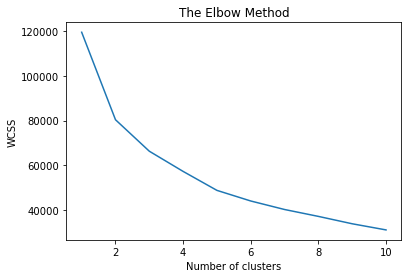

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 29)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The optimal number of clusters seems to be 5, so let us proceed with that.

In [9]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 29)
y_kmeans = kmeans.fit_predict(X)

Our cluster labels are now stored in y_kmeans. We will add that as a column to our `data` variable:

In [10]:
data['ClusterID'] = y_kmeans
data.head()

,Track,Artist,Genre,BPM,Energy,Danceability,Loudness,Liveness,Valence,Acousticness,Speechiness,Popularity,ClusterID
0,Señorita,Shawn Mendes,10,117,55,76,-6,8,75,4,3,79,1
1,China,Anuel AA,13,105,81,79,-4,8,61,8,9,92,1
2,boyfriend (with Social House),Ariana Grande,10,190,80,40,-4,16,70,12,46,85,0
3,Beautiful People (feat. Khalid),Ed Sheeran,10,93,65,64,-8,8,55,12,19,86,1
4,Goodbyes (Feat. Young Thug),Post Malone,6,150,65,58,-4,11,18,45,7,94,2


Our curated playlist generator is now ready.

### Implementation

Spotify's playlist recommendations look something like this:



![My daily playlist recommendation](https://rainnews.com/wp-content/uploads/2016/09/spotify-daily-mix.png)

We have done the same to curate the Top 50 songs in our dataset into 5 playlists based on the features of the song, i.e. genre, energy, danceability, loudness etc.

In [11]:
data.sort_values(by=['ClusterID'], inplace=True)

for clusternumber in data.ClusterID.unique():
    print("\nPlaylist Number: " + str(clusternumber+1))
    print(data.loc[data.ClusterID == clusternumber, ['Track', 'Artist']])


Playlist Number: 1
                             Track          Artist
2    boyfriend (with Social House)   Ariana Grande
46                       Te Robaré       Nicky Jam
38                          Sucker  Jonas Brothers
37  Antisocial (with Travis Scott)      Ed Sheeran
36                      Otro Trago            Sech
13              Otro Trago - Remix            Sech

Playlist Number: 2
                                            Track        Artist
0                                        Señorita  Shawn Mendes
47                                        Happier    Marshmello
41                          You Need To Calm Down  Taylor Swift
32                              0.958333333333333        Maluma
29                                  QUE PRETENDES      J Balvin
28                                      Con Calma  Daddy Yankee
23                                Soltera - Remix         Lunay
22                           No Me Conoce - Remix   Jhay Cortez
20                         

### Thank you for reading! If you liked my notebook, please leave an upvote!